In [1]:
import numpy as np
import matplotlib
import matplotlib.patches as patches
%matplotlib inline
from keras.models import load_model

import skimage
from skimage.transform import resize
from skimage import measure
from skimage.measure import regionprops
import matplotlib.patches as patches
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.filters import threshold_otsu

import warnings
warnings.filterwarnings("ignore")

/home/mehdi/anaconda3/envs/py3-clean/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
model = load_model('./model/mnist_model.h5')

In [3]:
def embed_into_sq(img):
    '''
    embeds an array into a square array and leaves some margin around it
    '''
    m, n = img.shape
    M = max(m, n)
    padding = int(M/4) # 1/4 is a tuned parameter 
    canvas = np.zeros((M+padding*2,M+padding*2))
    if m == M:
        for i in range(m):
            for j in range(n):
                canvas[padding+i, padding+(M-n)//2+j] = (1-img[i,j])*255
    elif n == M:
        for i in range(m):
            for j in range(n):
                canvas[padding+(M-m)//2+i, padding+j] = (1-img[i,j])*255
    return canvas
    
def predict_array(my_array, model=model, show_image=True):
    '''
    Runs the keras model on each image
    '''
    if show_image:
        plt.imshow(my_array, matplotlib.cm.binary, interpolation='nearest')
        plt.show()
    x = skimage.transform.resize(my_array, output_shape=(28,28)).reshape((1, 28,28,1))
    x /= 256
    prediction = model.predict(x)
    prediction = np.argmax(prediction)
    if show_image:
        print("Your algorithm predicts: y = " + str(prediction))
    return prediction

def process_img(file_name, show_img=False):
    '''
    - Prints a gray and a binay of the image
    - Extracts items from the image and a returns a dict or something
    '''
    file_name = str(file_name)
    image = imread(file_name, as_grey=True) # a 2D array

    gray_image = image * 255
    threshold_value = threshold_otsu(gray_image)
    binary_image = gray_image > threshold_value
    binary_image_inv = np.invert(binary_image)
    labelled_image = measure.label(binary_image_inv)

    fig, ax1 = plt.subplots(1)
    ax1.imshow(gray_image, cmap="gray")

    characters = []
    counter=0
    column_list = []
    centers = []
    heights = []
    widths = []

    for regions in regionprops(labelled_image):
        y0, x0, y1, x1 = regions.bbox
        region_height = y1 - y0
        region_width = x1 - x0
        
        #if x1-x0 < 10: # adjust sensitivity to the sizes of detected objects
        #    continue
            
        x_center = (x0 + x1)*0.5
        y_center = (y0 + y1)*0.5

        #if region_height > min_height and region_height < max_height and region_width > min_width and region_width < max_width:
        image_cropped = image[y0:y1, x0:x1]

            # draw a red bordered rectangle over the character.
        rect_border = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, edgecolor="blue",
                                        linewidth=2, fill=False)
        height = y1 - y0
        width = x1 - x0
        
        ax1.add_patch(rect_border)
        
        # collect heights and widths
        heights.append(height)
        widths.append(width)
        # collect the centers
        centers.append((x_center, y_center))
        # collect the corresponding arrays representing the images
        characters.append(image_cropped)

    print('Size: ',len(characters))
    
    plt.show()
    
    avg_height = np.average(heights)
    avg_width = np.average(widths)
    
    char_dict = {}
    for i in range(len(centers)):
        char_dict[centers[i]] = characters[i]    
                    
    return characters, char_dict, centers, avg_height, avg_width

def catcher(y_pivot, epsilon, bag_of_things):
    '''
    This picks up any element from "bag_of_things" whose y-values is within range epsilon from y_pivot
    '''
    
    out = []
    L = len(bag_of_things)
    
    for i in range(L):
        y = bag_of_things[i][1]
        if y < y_pivot + epsilon and y > y_pivot - epsilon:
            out.append(bag_of_things[i])
    
    return out

def catch_all(bag_of_things, epsilon):
    '''
    This makes a list of all tuples whose y-values are close enough. 
    Each class contains the digits that land on the same line. 
    '''
    
    L = len(bag_of_things)
    
    out = [set(catcher(bag_of_things[i][1], epsilon, bag_of_things)) for i in range(L)]
    out = set(frozenset(out[i]) for i in range(len(out)))
    out = [list(x) for x in out]
    
    return out

def find_y_val(bag_of_points, x):
    size = len(bag_of_points)
    
    for p in bag_of_points:
        if p[0] == x:
            y = p[1]
            break
    
    return y

def separate_gaps(bag_of_points, avg_width, err_coeff=0.38):
    '''
    bag_of_points - a list of points with the coordinates of the centers
    err_coeff - determines how much error is allowed for the distance between neighbor characters    
    outputs - separated list of digits
    '''
    
    # sort by x-values
    X = [p[0] for p in bag_of_points]
    X_sorted = sorted(X)
    
    distance = avg_width * (1+err_coeff)
    size = len(X)    
    leaps = [0] # initiate with zero included
    
    for i in range(1, size):
        leap = X_sorted[i] - X_sorted[i-1]
        if leap > distance:
            leaps.append(i) # add i every time there's a gap
            
    leaps.append(size) # also include the last element (for technical reasons below)

    len_leaps = len(leaps)        
    
    intervals = []

    for i in range(len_leaps-1):
            intervals.append(X_sorted[leaps[i]:leaps[i+1]]) 
    
    return intervals  

def get_points(X, bag_of_points):
    '''
    X - a list of x-values of points
    bag_of_points - all points
    
    returns: (x,y) for all x in X
    '''
    return [(x,find_y_val(bag_of_points, x)) for x in X]

def center_of_mass(ordered_centers, avg_height, avg_width):
    '''
    This computes the center of a string of ordered characters and the coordinates of a box around it
    '''
    p = ordered_centers[0] # first point
    q = ordered_centers[-1] # last point
    
    x_center = (0.5)*(p[0]+q[0])
    y_center = (0.5)*(p[1]+q[1])
    
    sw_point = (p[0]-avg_width/2., p[1]-avg_height/2.) # south-west point
    ne_point = (q[0]+avg_width/2., q[1]+avg_height/2.) # north_east point
    
    return x_center, y_center, sw_point, ne_point   
    
def read_chars(bag_of_points, avg_height, avg_width, centers, char_dict, model):
    '''
    points - a list of centers on the same line (an element in the output of catch_all)
    
    output: the numbers with the coordinates
    '''
    intervals = separate_gaps(bag_of_points, avg_width, err_coeff=0.38)
    out_dict = {}

    for X in intervals:
        leng = len(X)
        
        for i in range(leng):
            XY = get_points(X, centers) # all centers of points with x's in X 
            size = len(XY) # the number of characters in X
            digits = []
            for j in range(size):
                img = char_dict[XY[j]] # look up the array with the given center XY[i]
                img = embed_into_sq(img) # normalize the img
                img_prediction = predict_array(img, model, show_image=False) # throw at the predictor
                digits.append(img_prediction)
                out = ''
                for k in range(len(digits)):
                    out+=str(digits[k])
            out_dict[out] = center_of_mass(XY, avg_height, avg_width)
    return out_dict

def process(file_name, model, epsilon = 0.2):
    '''
    returns a dict with recognized chars as keys and their coordinates as values
    '''
    
    file_name = str(file_name)    
    characters, char_dict, centers, avg_height, avg_width = process_img(file_name)
    
    A = catch_all(centers, epsilon*avg_height)
    B = [read_chars(A[i], avg_height, avg_width, centers, char_dict, model).keys() for i in range(len(A))]
    C = [read_chars(A[i], avg_height, avg_width, centers, char_dict, model) for i in range(len(A))]
    
    out_dikt = {}
    
    for dikt in C:
        keys = list(dikt.keys())
        for key in keys:
            out_dikt[key] = dikt[key]
    
    return out_dikt

def conv2int(L):
    return [int(n) for n in L]

def rec_nums(file_name, out_dict):
    '''
    out_dict - contains the char labels and their coordinats
    
    output - a list of numbers as integers
    '''
    
    keys = out_dict.keys()
    keys = list(keys)

    file_name = str(file_name)
    image = imread(file_name, as_grey=True) # a 2D array

    gray_image = image * 255

    fig, ax1 = plt.subplots(1)
    ax1.imshow(gray_image, cmap="gray")   
    
    for key in keys:
        x_center, y_center, sw_point, ne_point = out_dict[key]

        x0, y0 = sw_point
        x1, y1 = ne_point

            # draw a red bordered rectangle over the character.
        rect_border = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, edgecolor="green",
                                        linewidth=2, fill=False)
        ax1.add_patch(rect_border)
    plt.show()
    keys = [int(n) for n in keys]
    
    return keys

def isPrime(n, print_div=False):
    m = np.sqrt(n)
    m = int(m)
    out = True
    i = 2
    while(i <= m and out == True):
        if n % i == 0:
            out = False
            if print_div:
                print(str(n)+' is not prime: '+str(i)+'|'+str(n))
        i +=1
    if out:
        print(str(n)+' is prime.')
    return out

def tip_calc(n, percentage=15):
    return n*(1+(15/100))

Size:  31


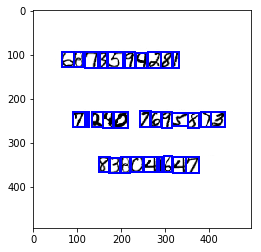

In [4]:
C = process("./img/sample.jpg", model) # dict with the numbers and their coordinates

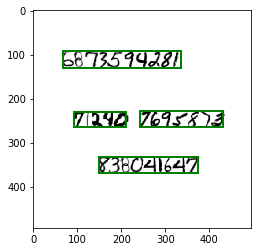

[7695873, 838041647, 6813594281, 71240]

In [5]:
nums = rec_nums("./img/sample.jpg", C)
nums

In [6]:
np.sum(nums)

7659403041

In [7]:
for n in nums:
    isPrime(n, True)

7695873 is not prime: 3|7695873
838041647 is prime.
6813594281 is not prime: 13|6813594281
71240 is not prime: 2|71240


In [8]:
for n in nums:
    print(tip_calc(n))

8850253.95
963747894.05
7835633423.15
81926.0


Size:  104


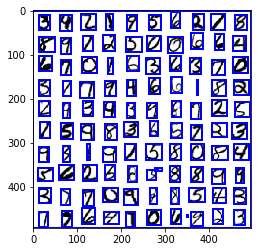

In [9]:
process("./img/mnist.jpg", model); # dict with the numbers and their coordinates

Size:  10


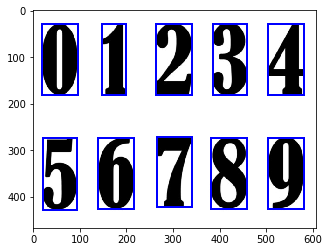

In [10]:
process("./img/nums1.jpg", model); # dict with the numbers and their coordinates

Size:  12


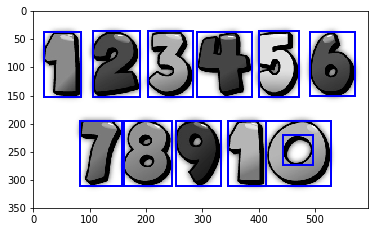

In [11]:
process("./img/nums2.jpg", model); # dict with the numbers and their coordinates

Size:  250


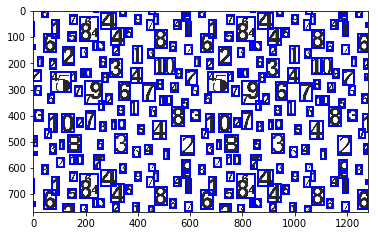

In [12]:
process("./img/nums3.jpg", model); # dict with the numbers and their coordinates

Size:  833


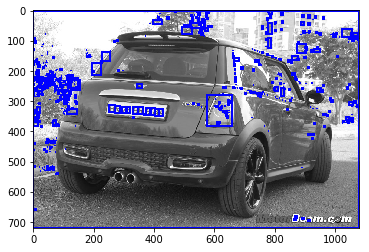

In [13]:
process("./img/car.jpg", model); # dict with the numbers and their coordinates